In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import datetime
import copy
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
import torch.nn.functional as F
from models.Buffer import Buffer
from models.DeepGenerator import GeneratorPolicy
from models.Discriminator import Discriminator
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *

In [2]:
# Training Folder
#path = r"..\data\pretuning"
#timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
#folder_name = f"Pretuning - {timestamp}"

path = r"..\models\trained_policies"

#save_dir = os.path.join(path, folder_name)
os.makedirs(path, exist_ok=True)

data_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\flagged\yolo_tensors'
hl_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\flagged\hl_tensors'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = GeneratorPolicy(features=4).to(device)
pred_policy.set_parameters(init=True)

prey_policy = GeneratorPolicy(features=5).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device=device)

In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(data_path)
expert_buffer.clear(p=95)               # Reduce ratio of non-attack data by 90%. now ~equal
# 70 ist hier zu wenig. Mehr auf hand-labeled trainieren
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
expert_buffer.add_expert(hl_path)
len_exp_pred, len_exp_prey = expert_buffer.lengths()

print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  3185
Storage of Prey Expert Buffer:  77648 



In [5]:
def pretrain_policy_with_validation(policy, expert_buffer, role, val_ratio=0.2, pred_bs=256, prey_bs=512, epochs=10, lr=1e-3, device='cpu', early_stopping=True, patience=20):
    if role == 'predator':
        batch, _ = expert_buffer.sample(pred_bs, prey_bs)
    else:
        _, batch = expert_buffer.sample(pred_bs, prey_bs)

    if role == 'predator':
        states  = batch[..., :4]
        actions = batch[:, 0, 4].squeeze()
    else:
        states  = batch[..., :5]
        actions = batch[:, 0, 5].squeeze()

    dataset = TensorDataset(states, actions)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    bs = pred_bs if role=='predator' else prey_bs
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False)

    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    train_losses, val_losses = [], []

    # Early-Stopping-Tracking
    patience_counter = 0
    best_val_loss = float('inf')
    best_state = copy.deepcopy(policy.state_dict())
    stopped_early = False

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        policy.train()
        total_train_loss = 0.0
        for batch_states, batch_actions in train_loader:
            batch_states  = batch_states.to(device)
            batch_actions = batch_actions.to(device)

            pred_out = policy.forward_pred(batch_states) if role == 'predator' else policy.forward_prey(batch_states)
            loss = F.mse_loss(pred_out, batch_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_states.size(0)

        avg_train_loss = total_train_loss / train_size
        train_losses.append(avg_train_loss)

        # ---- Validation ----
        policy.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_states, batch_actions in val_loader:
                batch_states  = batch_states.to(device)
                batch_actions = batch_actions.to(device)
                pred_out = policy.forward_pred(batch_states) if role == 'predator' else policy.forward_prey(batch_states)
                loss = F.mse_loss(pred_out, batch_actions)
                total_val_loss += loss.item() * batch_states.size(0)

        avg_val_loss = total_val_loss / val_size
        val_losses.append(avg_val_loss)

        # best checkpoint nach Val-Loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = copy.deepcopy(policy.state_dict())

        print(f"[{role.upper()}] Epoch {epoch:02d}  Train Loss: {avg_train_loss:.6f}  Val Loss: {avg_val_loss:.6f}")

        if early_stopping:
            if avg_val_loss > avg_train_loss:
                patience_counter += 1
            else:
                patience_counter = 0

            if patience_counter >= patience:
                print(f"[{role.upper()}] Early stopping nach {epoch} Epochen (Val > Train {patience}× in Folge).")
                stopped_early = True
                break

    # bestes Modell wiederherstellen
    policy.load_state_dict(best_state)

    # Plot
    epochs_run = len(train_losses)
    plt.figure()
    plt.plot(range(1, epochs_run + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs_run + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{role.capitalize()} Loss Curves" + (" (early stopped)" if stopped_early else ""))
    plt.legend()
    plt.show()

    return policy

[PREDATOR] Epoch 01  Train Loss: 0.465204  Val Loss: 0.518589
[PREDATOR] Epoch 02  Train Loss: 0.475637  Val Loss: 0.450789
[PREDATOR] Epoch 03  Train Loss: 0.462406  Val Loss: 0.483420
[PREDATOR] Epoch 04  Train Loss: 0.440264  Val Loss: 0.439712
[PREDATOR] Epoch 05  Train Loss: 0.463734  Val Loss: 0.397404
[PREDATOR] Epoch 06  Train Loss: 0.476195  Val Loss: 0.414450
[PREDATOR] Epoch 07  Train Loss: 0.449513  Val Loss: 0.442715
[PREDATOR] Epoch 08  Train Loss: 0.465353  Val Loss: 0.438777
[PREDATOR] Epoch 09  Train Loss: 0.431208  Val Loss: 0.486692
[PREDATOR] Epoch 10  Train Loss: 0.441314  Val Loss: 0.420418
[PREDATOR] Epoch 11  Train Loss: 0.469033  Val Loss: 0.494857
[PREDATOR] Epoch 12  Train Loss: 0.422091  Val Loss: 0.404597
[PREDATOR] Epoch 13  Train Loss: 0.447600  Val Loss: 0.433627
[PREDATOR] Epoch 14  Train Loss: 0.454321  Val Loss: 0.407841
[PREDATOR] Epoch 15  Train Loss: 0.439951  Val Loss: 0.392735
[PREDATOR] Epoch 16  Train Loss: 0.421956  Val Loss: 0.421089
[PREDATO

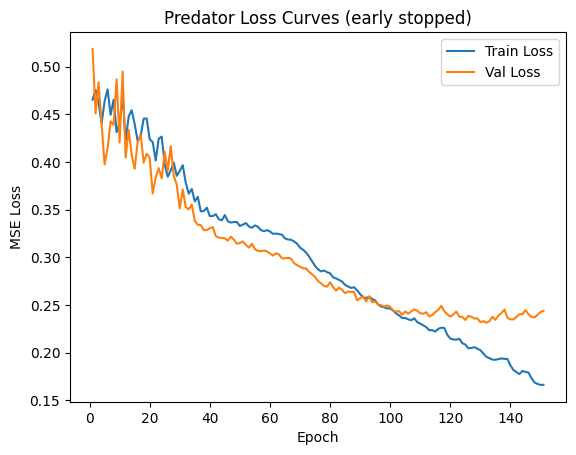

In [6]:
pred_policy = pretrain_policy_with_validation(pred_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=1024, prey_bs=2048, epochs=600, lr=1e-3, device='cpu', early_stopping=True, patience=50)
torch.save(pred_policy, os.path.join(path, "bc_pred_policy.pt"))

[PREY] Epoch 01  Train Loss: 0.379760  Val Loss: 0.376075
[PREY] Epoch 02  Train Loss: 0.383472  Val Loss: 0.380986
[PREY] Epoch 03  Train Loss: 0.376574  Val Loss: 0.377423
[PREY] Epoch 04  Train Loss: 0.374432  Val Loss: 0.389904
[PREY] Epoch 05  Train Loss: 0.379313  Val Loss: 0.376638
[PREY] Epoch 06  Train Loss: 0.371910  Val Loss: 0.359226
[PREY] Epoch 07  Train Loss: 0.368971  Val Loss: 0.373881
[PREY] Epoch 08  Train Loss: 0.360330  Val Loss: 0.371104
[PREY] Epoch 09  Train Loss: 0.369037  Val Loss: 0.359155
[PREY] Epoch 10  Train Loss: 0.369594  Val Loss: 0.355923
[PREY] Epoch 11  Train Loss: 0.373566  Val Loss: 0.359199
[PREY] Epoch 12  Train Loss: 0.348799  Val Loss: 0.357072
[PREY] Epoch 13  Train Loss: 0.344969  Val Loss: 0.344550
[PREY] Epoch 14  Train Loss: 0.361482  Val Loss: 0.365906
[PREY] Epoch 15  Train Loss: 0.354538  Val Loss: 0.372068
[PREY] Epoch 16  Train Loss: 0.334152  Val Loss: 0.355573
[PREY] Epoch 17  Train Loss: 0.345434  Val Loss: 0.329367
[PREY] Epoch 1

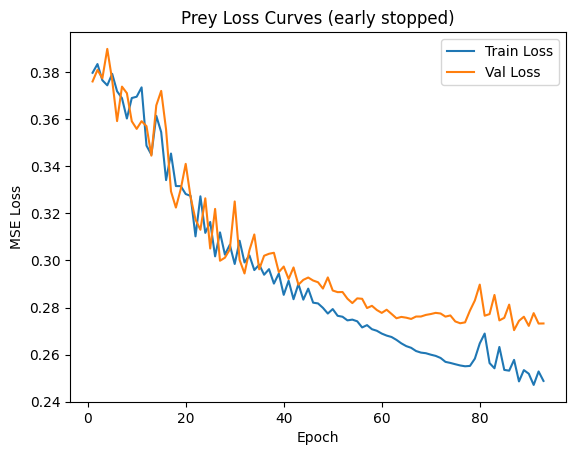

In [7]:
prey_policy = pretrain_policy_with_validation(prey_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=1024, prey_bs=2048, epochs=1000, lr=1e-3, device='cpu', early_stopping=True, patience=50)
torch.save(prey_policy, os.path.join(path, "bc_prey_policy.pt"))

In [8]:
# Expert Data
total_detections=33
ftw_path = rf"..\data\processed\pred_prey_interactions\full_track_windows\{total_detections}"

start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [9]:
env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=False)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy, prey_features=5)

Press 'q' to end simulation.
